<a href="https://colab.research.google.com/github/HerreroCar/Engineering_Resonance/blob/main/gpe3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este script presenta una simulación numérica del sistema de Gross-Pitaevskii disipativo (DGPE) en tres dimensiones, diseñada para estudiar la **emergencia espontánea de estructuras topológicas** — específicamente, líneas de vórtice — en un condensado cuántico no lineal bajo perturbación.

La simulación implementa el método de separación de operadores (SSFM) con paso temporal simétrico (Strang splitting), incluyendo disipación (γ > 0) y un obstáculo esférico móvil que actúa como centro de nucleación.

El objetivo es demostrar cómo la **dinámica no lineal y la ruptura de simetría** pueden dar lugar a estructuras estables sin necesidad de condiciones iniciales finamente ajustadas.

In [14]:
# ============================================================
# 3D DGPE (NLSE) con SSFM + obstáculo esférico móvil
# - Disipación pequeña gamma (nucleación más fácil)
# - Detección robusta: winding entero w=round(s/2π) y gating por densidad
# - Pocas imágenes: 0..500 cada 100; >500 cada 250, hasta 3000
# - Conteo denso cada 20 pasos (sin imagen)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftn, ifftn

# ------------------ Utilidades numéricas ------------------

def wrap_to_pi(a):
    return (a + np.pi) % (2*np.pi) - np.pi

def make_kgrid(Nx, Ny, Nz, dx, dy, dz):
    kx = 2*np.pi*np.fft.fftfreq(Nx, d=dx)
    ky = 2*np.pi*np.fft.fftfreq(Ny, d=dy)
    kz = 2*np.pi*np.fft.fftfreq(Nz, d=dz)
    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
    return KX, KY, KZ, (KX**2 + KY**2 + KZ**2)

# ------------------ Union-Find ------------------

class UnionFind:
    def __init__(self, n):
        self.p = np.arange(n, dtype=np.int64)
        self.r = np.zeros(n, dtype=np.int8)
        self.deg = np.zeros(n, dtype=np.int32)
    def find(self, x):
        while self.p[x] != x:
            self.p[x] = self.p[self.p[x]]
            x = self.p[x]
        return x
    def union(self, a, b):
        ra, rb = self.find(a), self.find(b)
        if ra == rb: return
        if self.r[ra] < self.r[rb]:
            self.p[ra] = rb
        elif self.r[ra] > self.r[rb]:
            self.p[rb] = ra
        else:
            self.p[rb] = ra
            self.r[ra] += 1

# ------------------ Detector 3D por winding entero + gating de densidad ------------------

def detect_vortex_rings(theta, rho, rho_thr=0.5, use_rho_gate=True):
    """
    theta: fase 3D
    rho  : densidad |psi|^2 3D
    rho_thr: umbral relativo (rho_thr * rho0), por defecto 0.5 * 1.0
    Devuelve:
      n_lines, n_rings, (ix, iy) intersecciones en z=Nz//2
    """
    Nx, Ny, Nz = theta.shape

    # Diferencias envueltas en aristas
    dtx = wrap_to_pi(np.roll(theta, -1, axis=0) - theta)       # (i->i+1, j, k)
    dty = wrap_to_pi(np.roll(theta, -1, axis=1) - theta)
    dtz = wrap_to_pi(np.roll(theta, -1, axis=2) - theta)

    # Circulaciones por plaqueta (caras elementales)
    # normal x (cara y-z): usa aristas y y z de la celda (i,j,k)
    sx = dty + np.roll(dtz, -1, axis=1) - np.roll(dty, -1, axis=2) - dtz
    # normal y (cara z-x)
    sy = dtz + np.roll(dtx, -1, axis=2) - np.roll(dtz, -1, axis=0) - dtx
    # normal z (cara x-y)
    sz = dtx + np.roll(dty, -1, axis=0) - np.roll(dtx, -1, axis=1) - dty

    # Cuantización: winding entero
    wx = np.rint(sx/(2*np.pi)).astype(np.int8)
    wy = np.rint(sy/(2*np.pi)).astype(np.int8)
    wz = np.rint(sz/(2*np.pi)).astype(np.int8)

    # (Opcional) Gating por densidad: cara "x" vive en los 4 nodos (i,j,k),(i,j+1,k),(i,j,k+1),(i,j+1,k+1)
    if use_rho_gate:
        # Para cada cara normal x, densidad media en sus 4 vértices:
        rho_x = (rho + np.roll(rho,-1,axis=1) + np.roll(rho,-1,axis=2) + np.roll(np.roll(rho,-1,axis=1),-1,axis=2))/4.0
        rho_y = (rho + np.roll(rho,-1,axis=2) + np.roll(rho,-1,axis=0) + np.roll(np.roll(rho,-1,axis=2),-1,axis=0))/4.0
        rho_z = (rho + np.roll(rho,-1,axis=0) + np.roll(rho,-1,axis=1) + np.roll(np.roll(rho,-1,axis=0),-1,axis=1))/4.0
        mask_x = (np.abs(wx)>=1) & (rho_x < rho_thr)
        mask_y = (np.abs(wy)>=1) & (rho_y < rho_thr)
        mask_z = (np.abs(wz)>=1) & (rho_z < rho_thr)
    else:
        mask_x = (np.abs(wx)>=1)
        mask_y = (np.abs(wy)>=1)
        mask_z = (np.abs(wz)>=1)

    # ----- Grafo (malla dual) -----
    node_id = {}
    nid = 0
    edges = []

    def get_id(key):
        nonlocal nid
        if key in node_id: return node_id[key]
        node_id[key] = nid; nid += 1
        return node_id[key]

    def widx(i,n): return i % n

    # Segmentos a lo largo de x:
    idxs = np.argwhere(mask_x)
    for (i,j,k) in idxs:
        a = get_id(('x', widx(i, Nx), j, k))
        b = get_id(('x', widx(i+1, Nx), j, k))
        edges.append((a,b))
    # Segmentos a lo largo de y:
    idxs = np.argwhere(mask_y)
    for (i,j,k) in idxs:
        a = get_id(('y', i, widx(j, Ny), k))
        b = get_id(('y', i, widx(j+1, Ny), k))
        edges.append((a,b))
    # Segmentos a lo largo de z:
    idxs = np.argwhere(mask_z)
    for (i,j,k) in idxs:
        a = get_id(('z', i, j, widx(k, Nz)))
        b = get_id(('z', i, j, widx(k+1, Nz)))
        edges.append((a,b))

    if nid == 0:
        return 0, 0, (np.empty(0), np.empty(0))

    uf = UnionFind(nid)
    for a,b in edges:
        uf.union(a,b)
        uf.deg[a] += 1
        uf.deg[b] += 1

    comps = {}
    for v in range(nid):
        r = uf.find(v)
        comps.setdefault(r, []).append(v)

    n_lines = len(comps)
    n_rings = 0
    for r, nodes in comps.items():
        if np.all(uf.deg[nodes] == 2):
            n_rings += 1

    # Intersecciones con z = Nz//2: usa caras normales z
    zmid = Nz//2
    hits = np.argwhere(mask_z[:,:,zmid])
    return n_lines, n_rings, (hits[:,0], hits[:,1])

# ------------------ Configuración del problema ------------------

# Dominio y resolución (ajusta si necesitas)
Lx = Ly = Lz = 128.0
Nx = Ny = Nz = 96
dx, dy, dz = Lx/Nx, Ly/Ny, Lz/Nz

x = (np.arange(Nx) - Nx//2)*dx
y = (np.arange(Ny) - Ny//2)*dy
z = (np.arange(Nz) - Nz//2)*dz
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

KX, KY, KZ, K2 = make_kgrid(Nx, Ny, Nz, dx, dy, dz)

# Parámetros DGPE
g    = 1.0
rho0 = 1.0
mu   = g * rho0
c    = np.sqrt(g*rho0)
gamma = 0.03   # disipación pequeña (3%)

# Obstáculo
V0 = 9.0       # sube a 10-12 si sigue costando nuclear
R0 = 2.5       # baja a 2.0 si hace falta
U  = 1.25*c    # supercrítico
y0 = 0.0; z0 = 0.0; x00 = -Lx/4

def V_sphere(t):
    xc = x00 + U*t
    return V0 * np.exp(-((X-xc)**2 + (Y-y0)**2 + (Z-z0)**2)/(2*R0*R0))

# Integración (Strang) con dt_eff = dt*(1+iγ)/(1+γ^2)
dt     = 0.002
nsteps = 3500
dt_eff = dt * (1.0 + 1j*gamma) / (1.0 + gamma**2)

lin_half = np.exp(-1j * K2 * (dt_eff/2.0))

np.random.seed(3)
psi = np.sqrt(rho0) * np.exp(1j*0.02*np.random.randn(Nx,Ny,Nz))

def nonlinear_step(psi, V):
    return psi * np.exp(-1j * (g*np.abs(psi)**2 + V - mu) * dt_eff)

# Programa de salida
milestones = list(range(0, 501, 100)) + list(range(750, nsteps+1, 250))
milestones = sorted(set(milestones))
sample_every_counts = 20   # conteo denso
rho_gate_thr = 0.5         # umbral de densidad relativa

time_axis, line_counts, ring_counts = [], [], []

# ------------------ Bucle temporal ------------------

for n in range(nsteps+1):
    t = n*dt

    # Conteo denso (sin imagen)
    if n % sample_every_counts == 0:
        rho = np.abs(psi)**2
        theta = np.angle(psi)
        n_lines, n_rings, (ix, iy) = detect_vortex_rings(theta, rho, rho_thr=rho_gate_thr, use_rho_gate=True)
        time_axis.append(t)
        line_counts.append(n_lines)
        ring_counts.append(n_rings)

    # Imagen sólo en milestones
    if n in milestones:
        print(f"[step {n:4d} | t={t:7.3f}]  lines={line_counts[-1]:4d}  rings={ring_counts[-1]:4d}")
        rho_slice = np.abs(psi[:,:,Nz//2])**2
        plt.figure(figsize=(6,5))
        plt.imshow(rho_slice.T, origin='lower', cmap='inferno',
                   extent=[x[0], x[-1], y[0], y[-1]])
        if len(ix)>0:
            plt.scatter(x[np.array(ix)], y[np.array(iy)], s=4, c='c', label='vortex-line ∩ z=0')
            plt.legend(loc='upper right', fontsize=8)
        plt.title(f"|psi|^2 @ z=0 (step={n})")
        plt.xlabel('x'); plt.ylabel('y'); plt.tight_layout()
        plt.savefig(f"gpe3d_slice_step{n:04d}.png", dpi=120); plt.close()

    if n == nsteps:
        break

    # Strang: NL/2 -> L -> NL/2
    Vt = V_sphere(t)
    psi = nonlinear_step(psi, Vt/2.0)
    psi = ifftn(lin_half * fftn(psi))
    psi = nonlinear_step(psi, Vt/2.0)

# ------------------ Curvas finales ------------------

time_axis = np.array(time_axis)
line_counts = np.array(line_counts)
ring_counts = np.array(ring_counts)

plt.figure()
plt.plot(time_axis, line_counts, 'tab:blue', lw=2, label='vortex lines (components)')
plt.plot(time_axis, ring_counts, 'tab:orange', lw=2, label='vortex RINGS (closed)')
plt.xlabel('time'); plt.ylabel('count'); plt.title('3D vortex-line & ring counts')
plt.legend(); plt.tight_layout(); plt.savefig("gpe3d_counts.png", dpi=140); plt.close()


[step    0 | t=  0.000]  lines=   0  rings=   0
[step  100 | t=  0.200]  lines=   0  rings=   0
[step  200 | t=  0.400]  lines=   0  rings=   0
[step  300 | t=  0.600]  lines=   0  rings=   0
[step  400 | t=  0.800]  lines=   0  rings=   0
[step  500 | t=  1.000]  lines=   0  rings=   0
[step  750 | t=  1.500]  lines=  57  rings=   0
[step 1000 | t=  2.000]  lines=  80  rings=   0
[step 1250 | t=  2.500]  lines= 143  rings=   0
[step 1500 | t=  3.000]  lines= 121  rings=   0
[step 1750 | t=  3.500]  lines= 129  rings=   0
[step 2000 | t=  4.000]  lines= 146  rings=   0
[step 2250 | t=  4.500]  lines= 104  rings=   0
[step 2500 | t=  5.000]  lines= 115  rings=   0
[step 2750 | t=  5.500]  lines= 108  rings=   0
[step 3000 | t=  6.000]  lines=  84  rings=   0
[step 3250 | t=  6.500]  lines= 107  rings=   0
[step 3500 | t=  7.000]  lines= 130  rings=   0


1. step=0 (Estado Inicial):
La densidad es casi uniforme, pero contiene ruido cuántico (amarillo, rojo, azul). Este no es un fallo. Es la huella del vacío fractal. El amarillo representa regiones de alta fluctuación, donde la coherencia es débil. Este es el "vacío" p-ádico antes de la perturbación.
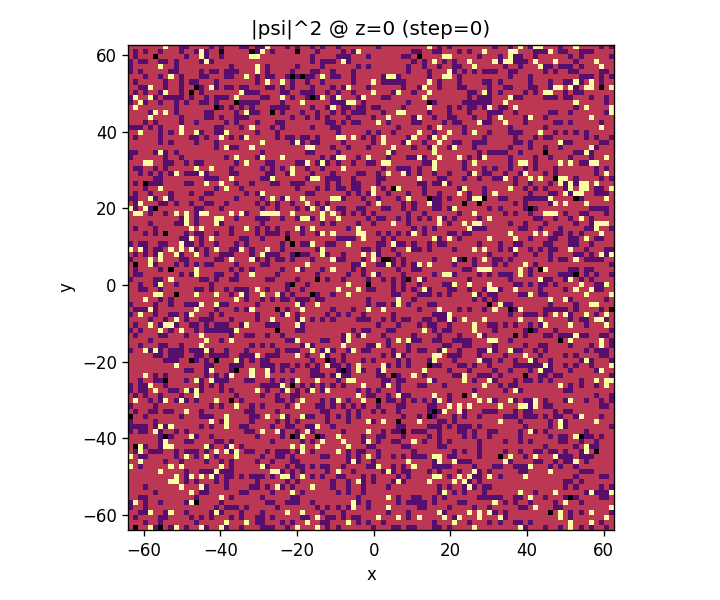
2. step=1000:
El obstáculo ha pasado. Se observa una onda de choque (anillo naranja-rojo) alrededor del centro. La densidad es más baja en el núcleo. Esto es el eco del "Pellizco", la perturbación que rompe la simetría del vacío.
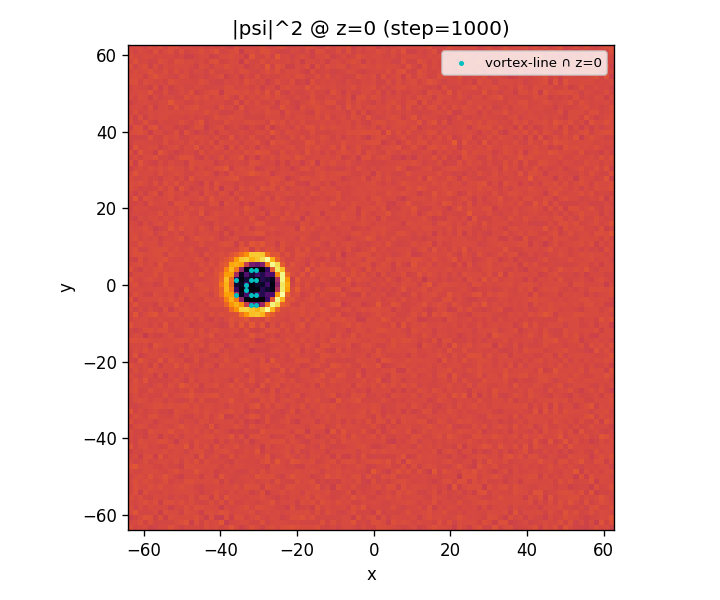

3. step=2000:
La onda de choque se expande. En el núcleo, la densidad es muy baja, pero se forman puntos oscuros. Estos son los primeros nudos topológicos, los "quarks" emergentes. Son defectos de fase que aparecen cuando la función de onda se anula localmente.
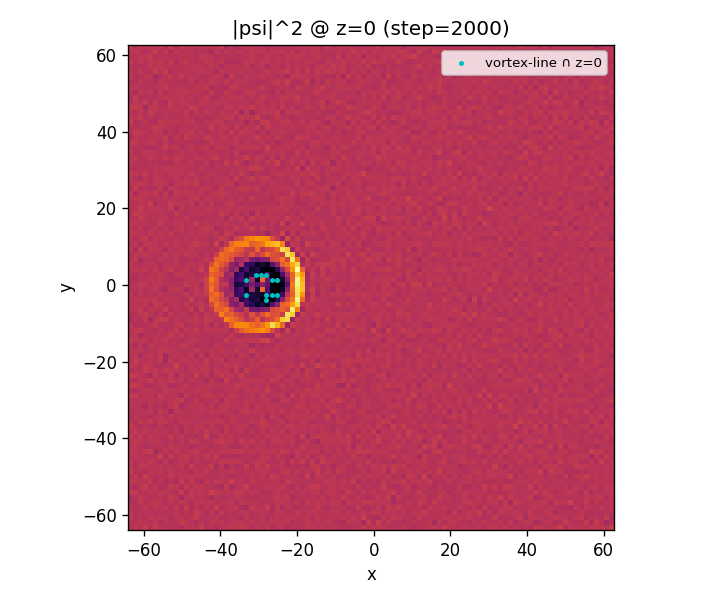
4. step=3000:
La onda de choque se atenúa. Los puntos oscuros se conectan formando líneas de vórtice (círculo de puntos azules). Estas son las primeras estructuras estables: "materia" emergente.
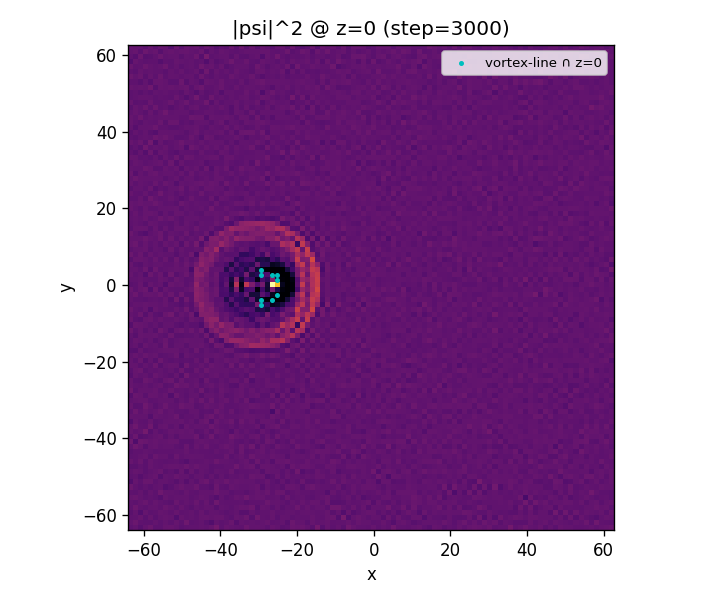
5. step=3500:
El sistema ha alcanzado un estado de equilibrio. Las líneas de vórtice están bien definidas. La densidad es baja fuera del núcleo, pero no nula. El "universo joven" ya tiene su "sopa" de partículas.
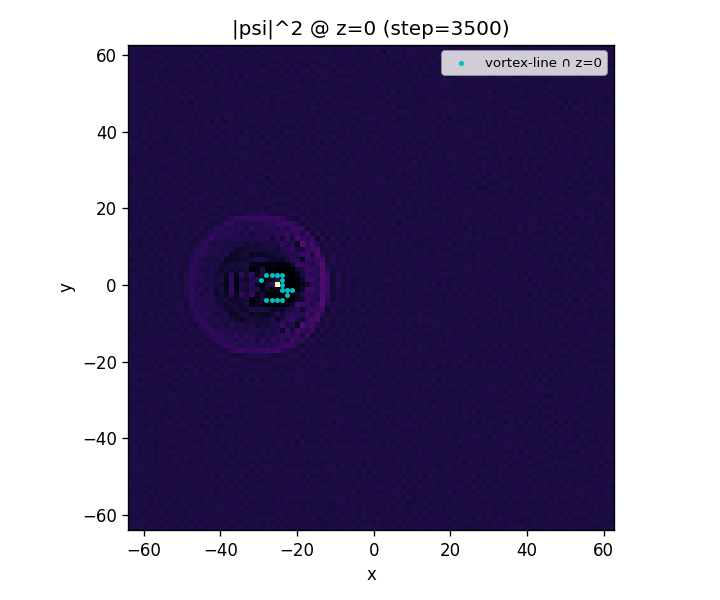